# Handwritten digits recognition using CNN

Importing essential libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import os
import csv
import itertools
from PIL import Image
from keras.initializers import Constant
from sklearn.metrics import confusion_matrix
%matplotlib inline

Using TensorFlow backend.


Data preprocessing

In [2]:
df = pd.read_csv('../input/msi-tinymnist2020/TinyMNIST/train.csv')
df.head()

,id,category
0,37172,5
1,37180,5
2,37185,5
3,37206,5
4,37208,5


In [3]:
y_train = np.array(df['category'])  #labels
y_train = keras.utils.to_categorical(y_train, num_classes=10)
print(len(y_train))

4000


JPEG
(28, 28)
L
Label:[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[[  0   0   0   0   0   0   0   0   3   0   4   0   0   8   3   1   9   0
    0   8   0   6   0   6   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   9   4   0   0   0   0   0  14
    0   9  23   0   6   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   4   7   0   0   7   1   3   5   4   0
    5   0   0   0   3   8   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   3   0   0   5   0   0   5   0   0
   10   5   0  35   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   5   8  12   7   0   0   3  10   0
    3   0   3   0   9   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   6   0   3   0   0  10   6   2   0   6
  122 247   6  17   3   8   0   0   0   0]
 [  0   0   0   0   0   0   0   0   3   0  21   0   0  10   0   0   0   2
  255 255   0   0   8   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  10 114  76   0   9   0   4   0 138
  240 255   0  16   0   0   0   0   0   0]
 [  0   0 

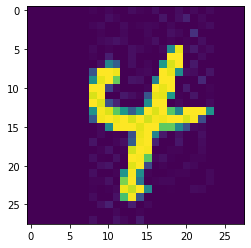

In [4]:
"""Sorting inputs by id so it'd fit to y_train array"""
x_train = []
for dirs ,subdirs, files in os.walk('../input/msi-tinymnist2020/TinyMNIST/train'):
    for file in files:
        x_train.append((file, dirs))
x_train.sort()
image = Image.open(f'{x_train[1122][1]}/{x_train[1122][0]}')  #random pic no 1122
"""Image data. Img size is the most crucial one."""
print(image.format)
print(image.size)
print(image.mode)
plt.imshow(image)
print(f'Label:{y_train[1122]}')  
print(np.array(image))  #converting pic to matrix

In [5]:
x_train = np.array([np.array(image) for image in[Image.open(f'{x_train[i][1]}/{x_train[i][0]}') for i in range(len(x_train))]])
x_eval = x_train[3800:]  # used to validate trained model (200 samples)
x_train = x_train[0:3800]

In [6]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32')
x_train /= 255 #data normalisation (fastens computing)
x_eval = x_eval.reshape(x_eval.shape[0], 28, 28, 1)
x_eval = x_eval.astype('float32')
y_eval = y_train[3800:]
y_train = y_train[0:3800]

Let's check arrays sizes before going on.

In [7]:
print(x_train.shape)
print(y_train.shape)
print(x_eval.shape)
print(y_eval.shape)

(3800, 28, 28, 1)
(3800, 10)
(200, 28, 28, 1)
(200, 10)


In [8]:
x_test = []
for dirs ,subdirs, files in os.walk('../input/msi-tinymnist2020/TinyMNIST/test'):
    for file in files:
        x_test.append((file, dirs))
x_test.sort()
nazwy_jpg = [file for file, dirs in x_test]
id_lst = [int(nazwa[4:].replace('.jpg', '')) for nazwa in nazwy_jpg]
x_test = np.array([np.array(image) for image in[Image.open(f'{x_test[i][1]}/{x_test[i][0]}') for i in range(len(x_test))]])
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32')
x_test /= 255
print(x_test.shape)

(600, 28, 28, 1)


Creating data generator for the sake of input increase -> may result with better accuracy

In [9]:
datagen = keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1,
        vertical_flip=False, # avoid flipping in digits coz 6 d be confused with 9
        horizontal_flip=False,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False)  # dont apply ZCA whitening 

Creating CNN model by using Sequential (keras lib) and fitting training data.

In [10]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=32,kernel_size=(5,5),padding='same',input_shape=(28,28,1)))
model.add(keras.layers.PReLU(alpha_initializer=Constant(value=0.25)))
model.add(keras.layers.Conv2D(filters=32,kernel_size=(5,5),padding='same'))
model.add(keras.layers.PReLU(alpha_initializer=Constant(value=0.25)))
model.add(keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Conv2D(filters=64,kernel_size=(5,5),padding='same'))
model.add(keras.layers.PReLU(alpha_initializer=Constant(value=0.25)))
model.add(keras.layers.Conv2D(filters=32,kernel_size=(5,5),padding='same'))
model.add(keras.layers.PReLU(alpha_initializer=Constant(value=0.25)))
model.add(keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256))
model.add(keras.layers.PReLU(alpha_initializer=Constant(value=0.25)))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(10, activation='softmax'))
    
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
annealer = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit_generator(datagen.flow(x_train,y_train, batch_size=128), epochs=50, validation_data=(x_eval, y_eval),
                    steps_per_epoch = x_train.shape[0]//128, callbacks=[annealer])

Epoch 1/50
29/29 [==============================] - 6s 196ms/step - loss: 1.4274 - accuracy: 0.5027 - val_loss: 16.0774 - val_accuracy: 0.9350
Epoch 2/50
29/29 [==============================] - 1s 41ms/step - loss: 0.5659 - accuracy: 0.8107 - val_loss: 26.0878 - val_accuracy: 0.9300
Epoch 3/50
29/29 [==============================] - 1s 47ms/step - loss: 0.3925 - accuracy: 0.8802 - val_loss: 9.7481 - val_accuracy: 0.9600
Epoch 4/50
29/29 [==============================] - 1s 42ms/step - loss: 0.3122 - accuracy: 0.9009 - val_loss: 9.1803 - val_accuracy: 0.9700
Epoch 5/50
29/29 [==============================] - 1s 42ms/step - loss: 0.2780 - accuracy: 0.9100 - val_loss: 9.9388 - val_accuracy: 0.9550
Epoch 6/50
29/29 [==============================] - 1s 42ms/step - loss: 0.2260 - accuracy: 0.9232 - val_loss: 6.2790 - val_accuracy: 0.9700
Epoch 7/50
29/29 [==============================] - 1s 42ms/step - loss: 0.2002 - accuracy: 0.9382 - val_loss: 8.2808 - val_accuracy: 0.9700

Epoch 000

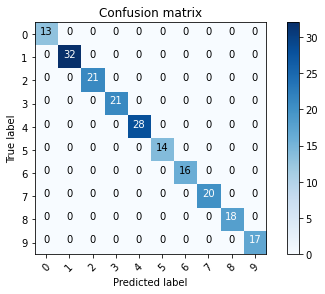

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_eval)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(y_eval,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_eval,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

Class predictions

In [12]:
y_test = model.predict_classes(x_test)
y_test = [int(pred) for pred in y_test]

CSV

In [13]:
dane_out =zip(id_lst,y_test)
d = dict(dane_out)
csv_data =[]
for k,v in sorted(d.items()):
    d = {}
    d['id'] = k
    d['category'] = v
    csv_data.append(d)

In [14]:
csv_columns = ['id', 'category']
csv_file = "test.csv"
with open(csv_file, 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
    writer.writeheader()
    for data in csv_data:
        writer.writerow(data)

Let's check if CSV file's fine

In [15]:
df2 = pd.read_csv('/kaggle/working/test.csv')
df2.head(10)

,id,category
0,0,1
1,1,0
2,2,1
3,3,4
4,4,0
5,5,0
6,6,7
7,7,3
8,8,5
9,9,3
